source of this function: https://github.com/OdysseasKr/neural-disaggregator <br>
metrics for GRU code: https://github.com/OdysseasKr/neural-disaggregator/blob/master/GRU/metrics.py  <br>

Nilmtk electric function, z ktorej bierze sie input do metrcs.py <br> 
source: https://github.com/nilmtk/nilmtk/blob/master/nilmtk/electric.py 


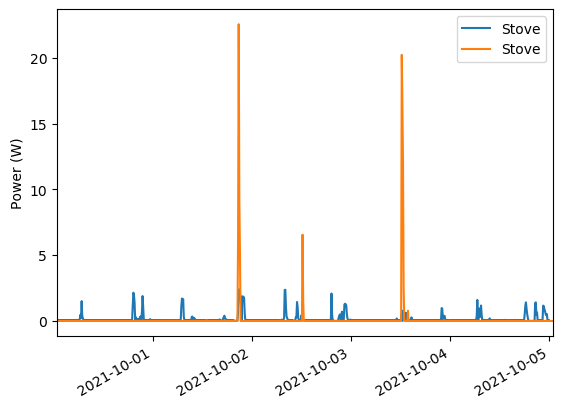

In [3]:
from nilmtk import DataSet 

test = DataSet(r'\Users\micki\nilmtk_test\data\converted_v14.h5')
test_elec = test.buildings[1].elec

result = DataSet('disag-outSEL_v08.h5')
res_elec = result.buildings[1].elec
predicted = res_elec['stove']
ground_truth = test_elec['stove']

import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.savefig('GRU_stove', dpi='figure')
plt.show()


In [4]:
plt.savefig('GRU_frdge', dpi='figure')

<Figure size 640x480 with 0 Axes>

(738064.0, 738066.0)

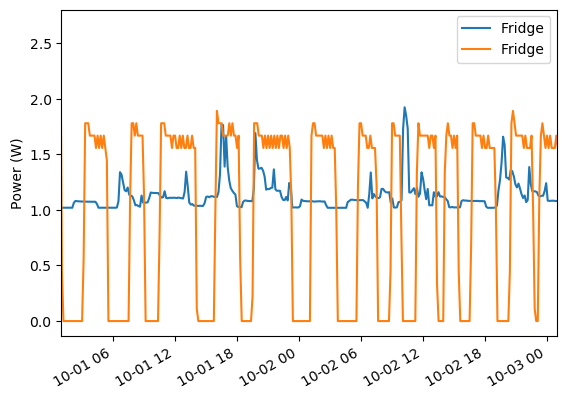

In [3]:
predicted.plot()
ground_truth.plot()

plt.xlim('2021-10-01','2021-10-03')

pomocne w nawigacji dataset'ow uzywanych w NILMTK: https://github.com/nilmtk/nilmtk/blob/master/docs/manual/user_guide/loading_data_into_memory.ipynb 

In [4]:

fridge = res_elec['fridge']
fridge.available_columns()

[('power', 'active')]

In [5]:
df = next(fridge.load())
df
#these are results of disaggregated fridge

,power
,active
2021-09-30 01:00:00+01:00,1.071743
2021-09-30 01:00:01+01:00,1.071743
2021-09-30 01:00:02+01:00,1.071743
2021-09-30 01:00:03+01:00,1.071743
2021-09-30 01:00:04+01:00,1.071743
...,...
2021-10-04 23:59:56+01:00,1.082386
2021-10-04 23:59:57+01:00,1.082386
2021-10-04 23:59:58+01:00,1.082386


In [6]:
# changing sampling frequency of predicted fridge
# https://stackoverflow.com/questions/25055712/pandas-every-nth-row 
# Dataframe.resample() works only with timeseries data. - alllegedly 
df3 = df.iloc[::60,:]
df3

,power
,active
2021-09-30 01:00:00+01:00,1.071743
2021-09-30 01:01:00+01:00,1.072978
2021-09-30 01:02:00+01:00,1.018751
2021-09-30 01:03:00+01:00,1.017737
2021-09-30 01:04:00+01:00,1.018796
...,...
2021-10-04 23:56:00+01:00,1.079450
2021-10-04 23:57:00+01:00,1.076876
2021-10-04 23:58:00+01:00,1.075579


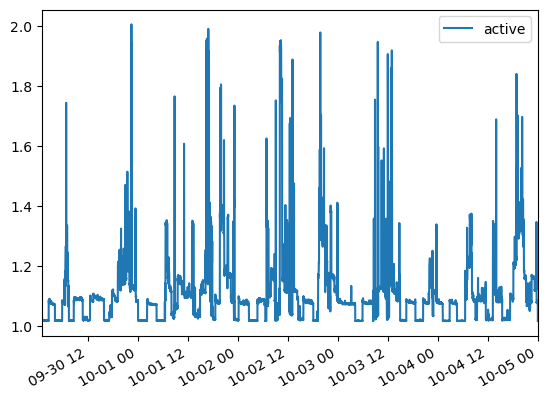

In [7]:
import matplotlib.pyplot as plt
#df3.iloc[:,0]
df3['power'].plot()
plt.show()

In [8]:
type(res_elec['fridge'])     # 21/02 11:11 CONTINUE FROM HERE :) 

nilmtk.elecmeter.ElecMeter

In [9]:
true_fridge = test_elec['fridge'] 
true_fridge.available_columns()

[('power', 'active')]

In [10]:
df1 = next(true_fridge.load())
df1
#these are results of the ground truth data of fridge, collected by the smart plugg 

physical_quantity,power
type,active
2021-09-30 01:00:00+01:00,0.0
2021-09-30 01:01:00+01:00,2.0
2021-09-30 01:02:00+01:00,1.0
2021-09-30 01:03:00+01:00,2.0
2021-09-30 01:04:00+01:00,2.0
...,...
2021-10-05 00:56:00+01:00,2.0
2021-10-05 00:57:00+01:00,1.0
2021-10-05 00:58:00+01:00,2.0


observation: </br> 
there is mismatch in data frequency. Predicted data has 1 sample per second and ground truth data has 1 sample per minute. <br>
hypothesis: if I can make them the same frequncy the problem will be solved. (I hope so) 

In [12]:
# scikit library from which I can take my metrics: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html 
#  R^2 (coefficient of determination) regression score function.

from sklearn.metrics import r2_score 

#acc = r2_score(list(df1['power']['active']), list(df3['power']['active']))

r2 = r2_score(df1.iloc[:7141], df3)
r2

-0.03905168984490093

In [13]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(df1.iloc[:7141], df3)
acc

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [14]:
x = df3['power']['active']


In [15]:

def rms_error_power(predictions, ground_truth):
    '''Compute RMS error in assigned power
    
    .. math::
            error^{(n)} = \\sqrt{ \\frac{1}{T} \\sum_t{ \\left ( y_t - \\hat{y}_t \\right )^2 } }
    Parameters
    ----------
    predictions, ground_truth : nilmtk.MeterGroup
    Returns
    -------
    error : pd.Series
        Each index is an meter instance int (or tuple for MeterGroups).
        Each value is the RMS error in predicted power for that appliance.
    '''

    error = {}

    both_sets_of_meters = iterate_through_submeters_of_two_metergroups(
        predictions, ground_truth)
    for pred_meter, ground_truth_meter in both_sets_of_meters:
        sum_of_squared_diff = 0.0
        n_samples = 0
        for aligned_meters_chunk in align_two_meters(pred_meter, 
                                                     ground_truth_meter):
            diff = aligned_meters_chunk.iloc[:, 0] - aligned_meters_chunk.iloc[:, 1]
            diff.dropna(inplace=True)
            sum_of_squared_diff += (diff ** 2).sum()
            n_samples += len(diff)

        error[pred_meter.instance()] = math.sqrt(sum_of_squared_diff / n_samples)

    return pd.Series(error)



In [16]:
# from nilmtk.metrics import rms_error_power 
# rms_error_power(predicted, ground_truth)

from sklearn.metrics import mean_squared_error
mean_squared_error(df1.iloc[:7141],df3)

0.82318175

In [17]:
test_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='SEL', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='SEL', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=3, building=1, dataset='SEL', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='SEL', appliances=[Appliance(type='kettle', instance=1)])
  ElecMeter(instance=5, building=1, dataset='SEL', appliances=[Appliance(type='stove', instance=1)])
)

In [18]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

C:\Users\micki\nilmtk_test\GRU\metrics.py:77: RuntimeWarning: invalid value encountered in true_divide
  return tp/float(tp+fp)


============ Recall: 0.0
============ Precision: nan
============ Accuracy: 0.016664293500715452
============ F1 Score: nan
============ Relative error in total energy: 0.9852609804462142
============ Mean absolute error(in Watts): 1.1041636090695233


In [16]:
from nilmtk.electric import align_two_meters
import numpy as np

tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
tp

NameError: name 'states_pred' is not defined

In [16]:
from nilmtk.electric import align_two_meters
import numpy as np

def tp_tn_fp_fn(states_pred, states_ground):
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

In [17]:
tp_tn_fp_fn(predicted, ground_truth)

(0, 0, 0, 0)

In [1]:
from nilmtk.electric import align_two_meters
import numpy as np

def tp_tn_fp_fn(states_pred, states_ground):
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

def recall_precision_accuracy_f1(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    threshold = ground.on_power_threshold()
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        sum_samples += len(chunk)
        pr = np.array([0 if (p)<threshold else 1 for p in chunk.iloc[:,0]])
        gr = np.array([0 if p<threshold else 1 for p in chunk.iloc[:,1]])

        tp, tn, fp, fn = tp_tn_fp_fn(pr,gr)
        p = sum(pr)
        n = len(pr) - p

        chunk_results.append([tp,tn,fp,fn,p,n])

    if sum_samples == 0:
        return None
    else:
        [tp,tn,fp,fn,p,n] = np.sum(chunk_results, axis=0)

        res_recall = recall(tp,fn)
        res_precision = precision(tp,fp)
        res_f1 = f1(res_precision,res_recall)
        res_accuracy = accuracy(tp,tn,p,n)

        return (res_recall,res_precision,res_accuracy,res_f1)

def relative_error_total_energy(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        E_pred = sum(chunk.iloc[:,0])
        E_ground = sum(chunk.iloc[:,1])

        chunk_results.append([
                            E_pred,
                            E_ground
                            ])
    if sum_samples == 0:
        return None
    else:
        [E_pred, E_ground] = np.sum(chunk_results,axis=0)
        return abs(E_pred - E_ground) / float(max(E_pred,E_ground))

def mean_absolute_error(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    total_sum = 0.0
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        total_sum += sum(abs((chunk.iloc[:,0]) - chunk.iloc[:,1]))
    if sum_samples == 0:
        return None
    else:
        return total_sum / sum_samples


def recall(tp,fn):
    return tp/float(tp+fn)

def precision(tp,fp):
    return tp/float(tp+fp)

def f1(prec,rec):
    return 2 * (prec*rec) / float(prec+rec)

def accuracy(tp, tn, p, n):
    return (tp + tn) / float(p + n)

In [2]:
tp

NameError: name 'tp' is not defined

In [ ]:
# align two meters 



def align_two_meters(master, slave, func='power_series'):
    """Returns a generator of 2-column pd.DataFrames.  The first column is from
    `master`, the second from `slave`.
    Takes the sample rate and good_periods of `master` and applies to `slave`.
    Parameters
    ----------
    master, slave : ElecMeter or MeterGroup instances
    """
    sample_period = master.sample_period()
    period_alias = '{:d}S'.format(sample_period)
    sections = master.good_sections()
    master_generator = getattr(master, func)(sections=sections)
    for master_chunk in master_generator:
        if len(master_chunk) < 2:
            return
        chunk_timeframe = TimeFrame(master_chunk.index[0],
                                    master_chunk.index[-1])
        slave_generator = getattr(slave, func)(sections=[chunk_timeframe])
        slave_chunk = next(slave_generator)

        # TODO: do this resampling in the pipeline?
        if not slave_chunk.empty:
            slave_chunk = slave_chunk.resample(period_alias).mean()
            
        if slave_chunk.empty:
            continue
            
        master_chunk = master_chunk.resample(period_alias).mean()

        yield pd.DataFrame({'master': master_chunk, 'slave': slave_chunk})

        